## Clustering

This is a Python tutorial, but feel free to attempt these exercises in R! Most of the algorithms below can be found in the ```library(cluster)```.

**Outline**
- Clustering 
- KMeans
- MeanShift
- DBSCAN
- Hierarchical clustering
- Gaussian Mixture Model

- Exercise
- Further reading

**Clustering**

Clustering is a type of unsupervised machine learning. Generally, it is just a way of grouping data. Data points that are in the same group should have some similar properties and data points that are not in the same group should have dissimilar properties. This 'sameness' can be measured in various ways. A very intuitive one, is Euclidian distance. But similarity measures can also be defined as density or entropy measures.

In general, clustering is an exploratory process, it can be very useful to find new patterns in a dataset and thus can help to form new hypothesis about the data.

Clustering algorithms can be grouped into mainly 4 categories: centroid-based clustering (e.g. KMeans), density-based clustering (e.g. DBSCAN), distribution-based clustering (e.g. Gaussian Mixture) and hierarchical clustering. 


**Choosing a similarity measure**

Measuring the similarity between two vectors (A,B).

<img src="similarity_measure.png" width="550" align="center">

In contrast to the cosine, the dot product is proportional to the vector length. This is important because examples that appear very frequently in the training set tend to have embedding vectors with large lengths. If you want to capture popularity, then choose dot product. However, the risk is that popular examples may skew the similarity metric. To balance this skew, you can raise the length to an exponent $α >1$ to calculate the dot product as $|a|^α |b|^αcos(θ)$.

To better understand how vector length changes the similarity measure, normalize the vector lengths to 1 and notice that the three measures become proportional to each other.

## Data: Breast Cancer Proteomes

The data is based on a paper (https://www.nature.com/articles/nature18003), in which the researchers use a K-Means clustering algorithm among other algorithms to find proteomic and phospoproteomic subtypes of breast cancer. 

In brief: the data were used to assess how the mutations in the DNA are affecting the protein expression landscape in breast cancer. Genes in our DNA are first transcribed into RNA molecules which then are translated into proteins. Changing the information content of DNA has impact on the behavior of the proteome, which is the main functional unit of cells, taking care of cell division, DNA repair, enzymatic reactions and signaling etc. They performed K-means clustering on the protein data to divide the breast cancer patients into sub-types, each having unique protein expression signature. They found that the best clustering was achieved using 3 clusters (original PAM50 gene set yields four different subtypes using RNA data).

There are three different files, which are desribed below:

*File: 77_cancer_proteomes_CPTAC_itraq.csv*

RefSeq_accession_number: RefSeq protein ID (each protein has a unique ID in a RefSeq database) 
gene_symbol: a symbol unique to each gene (every protein is encoded by some gene) 
gene_name: a full name of that gene 
Remaining columns: log2 iTRAQ ratios for each sample (protein expression data, most important), three last columns are from healthy individuals

*File: clinical_data_breast_cancer.csv*

First column "Complete TCGA ID" is used to match the sample IDs in the main cancer proteomes file (see example script). All other columns have self-explanatory names, contain data about the cancer classification of a given sample using different methods. 'PAM50 mRNA' classification is being used in the example script.

*File: PAM50_proteins.csv*

Contains the list of genes and proteins used by the PAM50 classification system. The column RefSeqProteinID contains the protein IDs that can be matched with the IDs in the main protein expression data set.


**Cleaning and merging of the data**

First, we will drop the "gene_symbol" and "gene_name" columns of *77_cancer_proteomes_CPTAC_itraq.csv*. Then we will match the patient id between the datasets and drop clinical entries from *clinical_data_breast_cancer.csv* for samples not in our protein dataset.
Finally, we merge the clinical and proteomes dataset and locate the "RefSeqProteinID" of the PAM50 proteins (from the *PAM50_proteins.csv* file).


**Impute missing values**

We will be using the ```SimpleImputer``` function from sklearn with 'median' strategy. There are different [impute functions](https://scikit-learn.org/stable/modules/impute.html) you could choose from. 


**Scaling the data**

In order for each variable to have the same impact on cluster selection, the data must be scaled. Scaling is especially important for cluster selection if you use Eucledian distance as a similarity metric. 
We will be using the [StandardScaler function](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), which performs a z-transformation on each of the numeric values. 

$z = \frac{x - \mu}{\sigma}$

You fit the standardscaler object on the training data (getting the $\mu$ and $\sigma\$ values) and then use the fitted object to transform the dataset.

In general, you should always impute the data before you scale it. 

Let's go!

If you don't have a package installed -like geopandas, altair or plotly_express - then use the command ```!pip install geopandas``` before importing the packages.

In [1]:
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import numpy as np
import itertools

from scipy import linalg
import sklearn
from sklearn.datasets import make_blobs, make_circles, make_moons

import plotly_express as px

import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from numpy import random
import seaborn as sb
import matplotlib.pyplot as plt 


import altair as alt
np.random.seed(31)
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (10,6)

### Visual cluster analysis

Clustering can be very intuative. Given the example below, we can instantly recognise three groups. Our brains cluster visual features automatically. Sorting out the washing, for example, is a way of clustering clothes in different groups by colour.

In [23]:
n_samples = 1500
random_state = 31
X, y = make_blobs(n_samples=n_samples, random_state=random_state)
X_ = StandardScaler().fit_transform(X)

Text(0.5, 1.0, 'Random Sample of Blobs')

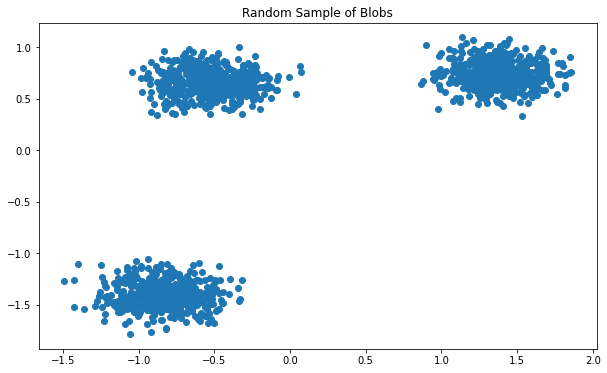

In [24]:
plt.scatter(X_[:, 0], X_[:, 1])
plt.title("Random Sample of Blobs")

For some other datasets this decision might no be as intuitve anymore. Let's assume we have the following dataset of two circles. How would you devide the data?

In [25]:
CirclesX, circlesy = make_circles(n_samples=n_samples, factor=.5, noise=.05, random_state = random_state)

CX = StandardScaler().fit_transform(CirclesX)

Text(0.5, 1.0, 'Random Sample of Circles')

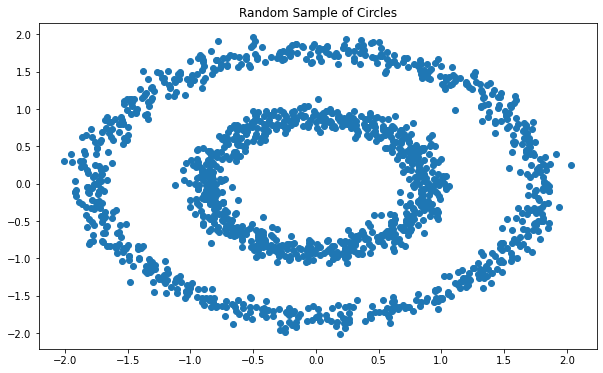

In [26]:
plt.scatter(CX[:, 0], CX[:, 1])
plt.title("Random Sample of Circles")

### Breast cancer proteomes dataset

Unfortunately, real-life data isn't usually as neat as the blob data above. The breast cancer proteomes dataset comes a bit closer. It is based on a paper (https://www.nature.com/articles/nature18003), in which the researchers use a K-Means clustering algorithm among other algorithms to find proteomic and phospoproteomic subtypes of breast cancer.

In [27]:
### Set path to the data set
dataset_path = "77_cancer_proteomes_CPTAC_itraq.csv"
clinical_info = "clinical_data_breast_cancer.csv"
pam50_proteins = "PAM50_proteins.csv"

## Load data
data = pd.read_csv(dataset_path,header=0,index_col=0)
clinical = pd.read_csv(clinical_info,header=0,index_col=0)## holds clinical information about each patient/sample
pam50 = pd.read_csv(pam50_proteins,header=0)

#### Data Preperation

Drop the columns 'gene_symbol', 'gene_name' and add the clinical meta data to the protein dataset. 
Select only the PAM50 proteins - known panel of genes used for breast cancer subtype prediction.

Finally, impute missing values.


In [28]:
## Drop unused information columns
data.drop(['gene_symbol','gene_name'],axis=1,inplace=True)

## Change the protein data sample names to a format matching the clinical data set
data.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)

## Transpose data for the clustering algorithm since we want to divide patient samples, not proteins
data = data.transpose()

## Drop clinical entries for samples not in our protein data set
clinical = clinical.loc[[x for x in clinical.index.tolist() if x in data.index],:]

## Add clinical meta data to our protein data set, note: all numerical features for analysis start with NP_ or XP_
merged = data.merge(clinical,left_index=True,right_index=True)

## Change name to make it look nicer in the code!
processed = merged

## Numerical data for the algorithm, NP_xx/XP_xx are protein identifiers from RefSeq database
processed_numerical = processed.loc[:,[x for x in processed.columns if bool(re.search("NP_|XP_",x)) == True]]

## Select only the PAM50 proteins - known panel of genes used for breast cancer subtype prediction
processed_numerical_p50 = processed_numerical.iloc[:,processed_numerical.columns.isin(pam50['RefSeqProteinID'])]

## Impute missing values (maybe another method would work better?)
imputer = SimpleImputer(strategy='median')
imputer = imputer.fit(processed_numerical_p50)
processed_numerical_p50 = imputer.transform(processed_numerical_p50)


processed_p50 = StandardScaler().fit_transform(processed_numerical_p50)


In [29]:
processed_numerical_p50.shape

(80, 43)

### K-Means

We will start with probably the most popular clustering algorithm there is. K-Means has stuck around for such a long time because it is very easy to implement and computationally efficient. 

K-Means finds the best centroids by alternating between (a) assigning data points to clusters based on the current centroids and (b) chosing centroids (points which are the center of a cluster) based on the current assignment of data points to clusters. 

<img src="kmeans.gif" width="450" align="center">

How do we know if the clustering algorithm is doing a good job?

If we don't have any ground truth data, validating a model can be very difficult. There are several measures that can describe some features of certain clusters. In these examples we will be using the silhouette score to define how distinct the clusters are.

The [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) is calculated using the mean intra-cluster distance ($a$) and the mean nearest-cluster distance ($b$) for each sample. The Silhouette Coefficient for a sample is $(b - a) / max(a, b)$.

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

But before we ge to the proteomes data, we will try the KMeans on our sample blobs and circles data.

In [30]:
from sklearn.cluster import KMeans

In [33]:
n_clusters = 3 #or 2 for second visualisation

kmeans = KMeans(n_clusters)
blobs = kmeans.fit(X_)
circles = kmeans.fit(CX)

b_labels = blobs.labels_
c_labels = circles.labels_

y_blobs_kmeans = blobs.predict(X_)
y_circle_kmeans = circles.predict(CX)

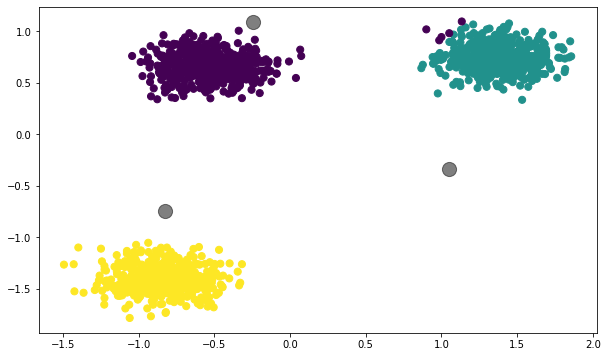

In [32]:
plt.scatter(X_[:, 0], X_[:, 1], c=y_blobs_kmeans, s=50, cmap='viridis')

centers = blobs.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

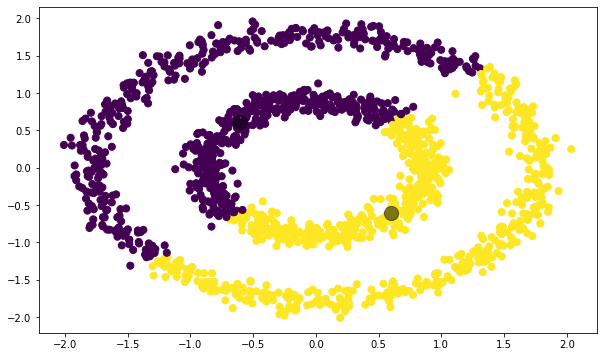

In [34]:
plt.scatter(CX[:, 0], CX[:, 1], c=y_circle_kmeans, s=50, cmap='viridis')

centers = circles.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

Let's calculate the silhouette score and the sum of squared errors for different Ks.

In [35]:
## Check which number of clusters works best 
n_cluster_list = [2,3,10] # there can't be more clusters as n

elb = []
silhouette = []
for n_clusters in n_cluster_list:
   #iterating through cluster sizes
   clusterer = KMeans(n_clusters = n_clusters, random_state=42)
   cluster_labels = clusterer.fit_predict(X_)
   #Finding the average silhouette score
   silhouette_avg = metrics.silhouette_score(X_, cluster_labels)
   silhouette.append(silhouette_avg)
   print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)
   #Finding the average SSE"
   elb.append(clusterer.inertia_) # Inertia: Sum of distances of samples to their closest cluster center


For n_clusters = 2 The average silhouette_score is : 0.6678980567564456
For n_clusters = 3 The average silhouette_score is : 0.8515814906343283
For n_clusters = 10 The average silhouette_score is : 0.3278099077528409


Now back to the real dataset: try out different values of k (ranging from 2 to 79) and calculate the silhouette score with the sklearn function ```metrics.silhouette_score(df, cluster_labels)``` for each KMeans. Save each silhouette score to a list called ```ss``` and the sum of distances of samples to their closest cluster center to a list called ```elbow```. The latter is defined as ```cluster.inertia_```, given cluster = KMeans(...).

Subsequently, create two different plots: one that captures the sum of squared error on the y-axis and the number of clusters (```n_cluster_list```) on the x-axis. Similarly, the second plot should capture the silhoutte score by number of cluster (```n_cluster_list```).

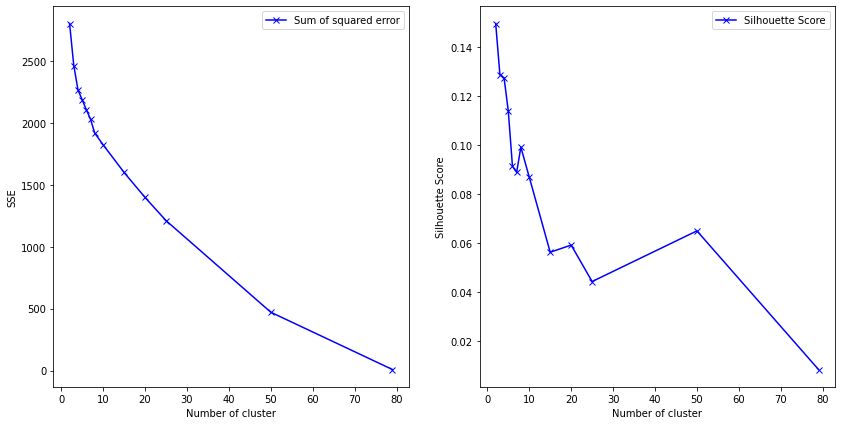

In [38]:
fig = plt.figure(figsize=(14,7))
fig.add_subplot(121)
plt.plot(n_cluster_list, elbow,'bx-',label='Sum of squared error')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.legend()
fig.add_subplot(122)
plt.plot(n_cluster_list, ss,'bx-',label='Silhouette Score')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

The left plot is the so-called 'elbow plot'. In cluster analysis, the elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.

As k increases, the sum of squared distance tends to zero. Imagine we set k to its maximum value n (where n is number of samples) each sample will form its own cluster meaning sum of squared distances equals zero. Usually the 'elbow' point of the plot (where the line bends) defines the ideal number of k.

In our case, this is quite difficult. I'd guess the 'elbow' would be around k = 5 or k = 7. Here the silhouette score shows us that it is decreasing from k = 2 to higher cluster numbers. 

#### Bonus:
Now that you know how the algorithm works, could you implement it yourself (without the ```Kmeans``` function)?
Hint: You could use the ```sklearn.metrics.pairwise_distances_argmin``` function for example.

### Mean Shift 

Mean shift clustering is a sliding-window-based algorithm that attempts to find dense areas of data points. It is a centroid-based algorithm meaning that the goal is to locate the center points of each group/class, which works by updating candidates for center points to be the mean of the points within the sliding-window. These candidate windows are then filtered in a post-processing stage to eliminate near-duplicates, forming the final set of center points and their corresponding groups. 

<img src="mean_shift.gif" width="350" align="center">

In contrast to K-means clustering, there is no need to select the number of clusters as mean-shift automatically discovers this. That’s a massive advantage. The fact that the cluster centers converge towards the points of maximum density is also quite desirable as it is quite intuitive to understand and fits well in a naturally data-driven sense. 
The drawback is that the selection of the window size/radius/bandwidth “r” can be non-trivial (a caveat that becomes more pertinent in higher dimensions). Speaking of high dimensionality, mean shift may also converge to local optima rather than global optima. But the biggest mark against Mean Shift is its computational expense. It runs at $O(Tn^2)$, compared to $O(kn*T)$ for k-means, where T is number of iterations and n represents the number of points. In fact, according to the sklearn documentation, the estimate_bandwidth function scales particularly badly.

In [27]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# estimate bandwidth for mean shift
bandwidth = estimate_bandwidth(X_, quantile=0.3)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)

c_bandwidth = estimate_bandwidth(CX, quantile=0.3)
msc = MeanShift(bandwidth=c_bandwidth, bin_seeding=True)

ms = ms.fit(X_)
ms_c = msc.fit(CX)

ms_cluster_centers = ms.cluster_centers_
ms_c_cluster_centers = ms_c.cluster_centers_

labels = ms.labels_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

labels_c = ms_c.labels_
labels_c_unique = np.unique(labels_c)
n_c_clusters_ = len(labels_c_unique)

y_msshift = ms.predict(X_)

circles_ymsshift = ms_c.predict(CX)

print("number of estimated clusters blobs: %d ," % n_clusters_,
     "number of estimated clusters circles: %d" % n_c_clusters_)

number of estimated clusters blobs: 3 , number of estimated clusters circles: 1


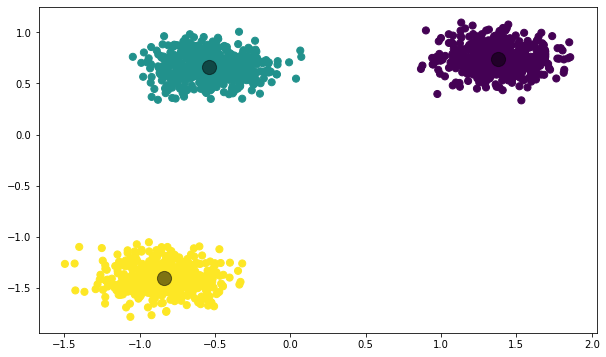

In [28]:
plt.scatter(X_[:, 0], X_[:, 1], c=y_msshift, s=50, cmap='viridis')

plt.scatter(ms_cluster_centers[:, 0], ms_cluster_centers[:, 1], c='black', s=200, alpha=0.5);

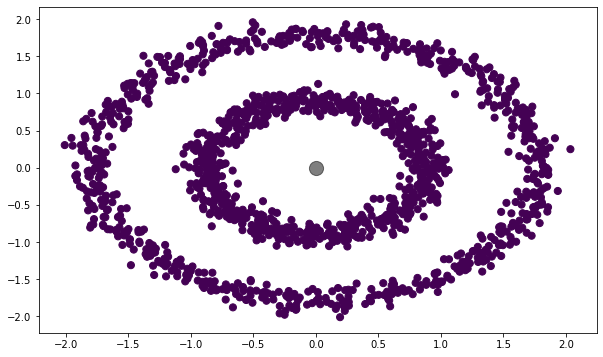

In [29]:
plt.scatter(CX[:, 0], CX[:, 1], c=circles_ymsshift, s=50, cmap='viridis')

plt.scatter(ms_c_cluster_centers[:, 0], ms_c_cluster_centers[:, 1], c='black', s=200, alpha=0.5);

In [30]:
# estimate bandwidth for mean shift
bandwidth = estimate_bandwidth(X_, quantile=0.3)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms = ms.fit(X_)
labels = ms.labels_
ms_cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

y_msshift = ms.predict(X_)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 3


Now, let's try it on our proteomes dataset:

### DBSCAN

DBSCAN (Density-based spatial clustering of applications with noise )is a density based clustering algorithm that can neatly handle noise (the clue is in the name). Clusters are considered zones that are sufficiently dense. Points that lack neighbours do not belong to any cluster and are thus classifed as noise (a state that is not immediately attainable under traditional k-means or HC). It poses some great advantages over other clustering algorithms. Firstly, it does not require a pre-set number of clusters at all. It also identifies outliers as noise, unlike mean-shift which simply throws them into a cluster even if the data point is very different. Additionally, it can find arbitrarily sized and arbitrarily shaped clusters quite well.
The main drawback of DBSCAN is that it doesn’t perform as well as others when the clusters are of varying density. This is because the setting of the distance threshold ε and minPoints for identifying the neighborhood points will vary from cluster to cluster when the density varies. This drawback also occurs with very high-dimensional data since again the distance threshold ε becomes challenging to estimate.

<img src="DBSCAN.gif" width="350" align="center">

In [39]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=2).fit_predict(X_)

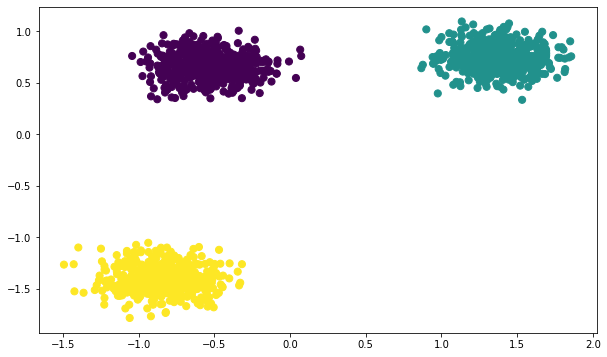

In [40]:
plt.scatter(X_[:, 0], X_[:, 1], c=db, s=50, cmap='viridis')

In [41]:
db_c = DBSCAN(eps=0.3, min_samples=2).fit_predict(CX)

While DBSCAN doesn’t require setting the number of clusters explicitly, setting eps implicitly controls how many clusters will be found.
Finding a good setting for eps is sometimes easier after scaling the data, as using these scaling techniques will ensure that all features have similar ranges.

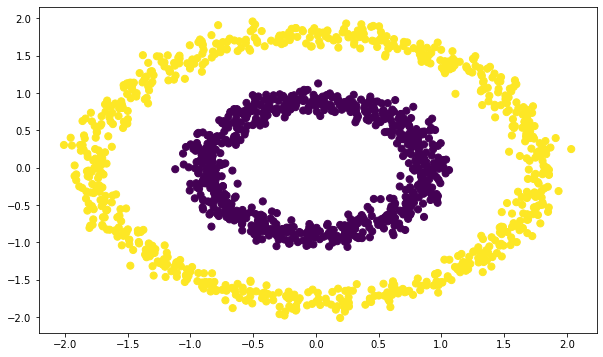

In [42]:
plt.scatter(CX[:, 0], CX[:, 1], c=db_c, s=50, cmap='viridis')

Amazing! The first algorithm that picks up those two rings as seperate clusters. Let's try the algorithm for our proteomes dataset.

### Agglomerative Clustering/ Hierarchical Clustering

Hierarchical clustering algorithms fall into 2 categories: top-down or bottom-up. Bottom-up algorithms treat each data point as a single cluster at the outset and then successively merge (or agglomerate) pairs of clusters until all clusters have been merged into a single cluster that contains all data points. Bottom-up hierarchical clustering is therefore called hierarchical agglomerative clustering or HAC. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample.

As its name suggests, it constructs a hierarchy of clusters based on proximity (e.g Euclidean distance or Manhattan distance- see GIF below). HC typically comes in two flavours (essentially, bottom up or top down):

    - Divisive: Starts with the entire dataset comprising one cluster that is iteratively split- one point at a time- until each point forms its own cluster.
    - Agglomerative: The agglomerative method in reverse- individual points are iteratively combined until all points belong to the same cluster.

Another important concept in HC is the linkage criterion. This defines the distance between clusters as a function of the points in each cluster and determines which clusters are merged/split at each step. That clumsy sentence is neatly illustrated in the GIF below

Hierarchical clustering does not require us to specify the number of clusters and we can even select which number of clusters looks best since we are building a tree. Additionally, the algorithm is not sensitive to the choice of distance metric; all of them tend to work equally well whereas with other clustering algorithms, the choice of distance metric is critical. A particularly good use case of hierarchical clustering methods is when the underlying data has a hierarchical structure and you want to recover the hierarchy; other clustering algorithms can’t do this. These advantages of hierarchical clustering come at the cost of lower efficiency, as it has a time complexity of O(n³), unlike the linear complexity of K-Means and GMM.

<img src="hierarch_1.gif" width="500" align="center">

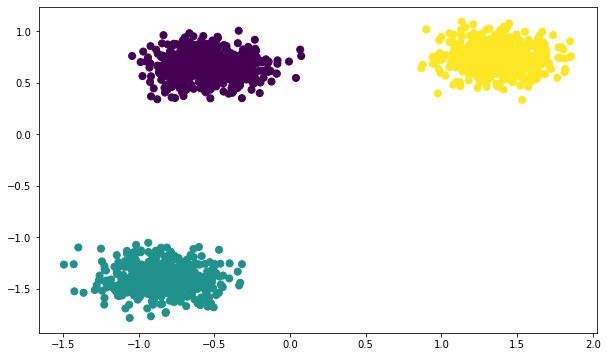

In [43]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3,
                                    linkage="average", affinity="euclidean").fit_predict(X_)

plt.scatter(X_[:, 0], X_[:, 1], c=agg, s=50, cmap='viridis')

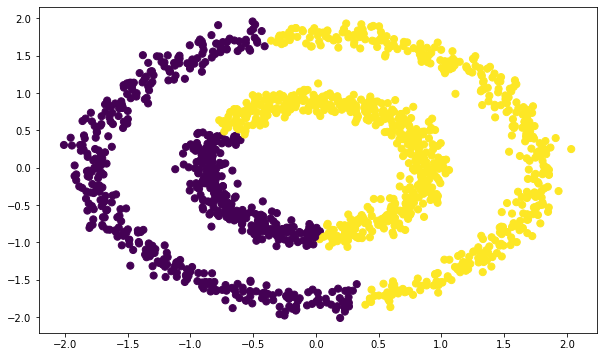

In [44]:
agg_c = AgglomerativeClustering(n_clusters=2,
                                    linkage="average", affinity="euclidean").fit_predict(CX)

plt.scatter(CX[:, 0], CX[:, 1], c=agg_c, s=50, cmap='viridis')

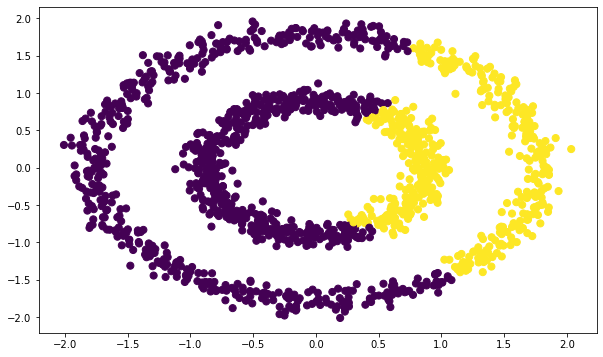

In [45]:
# maybe we'll get a different solution with the manhattan distance?

agg_c = AgglomerativeClustering(n_clusters=2,
                                    linkage="average", affinity="manhattan").fit_predict(CX)

plt.scatter(CX[:, 0], CX[:, 1], c=agg_c, s=50, cmap='viridis')

Now it's your turn: Try AgglomerativeClustering with the processed_p50 dataset. You can try different affinities and then print out the estimated number of clusters.

#### Plot dendogram

The dendrogram illustrates how each cluster is composed by drawing a U-shaped link between a non-singleton cluster and its children. The top of the U-link indicates a cluster merge. The two legs of the U-link indicate which clusters were merged. The length of the two legs of the U-link represents the distance between the child clusters. It is also the cophenetic distance between original observations in the two children clusters.

In [42]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Plot the dendrogram for the agglomerative clustering on the preprocsesed_p50 dataset below. Add the arguments ```truncate_mode='level``` and ```p=5``` to the ```plot_dendrogram``` function to plot the top five levels of the dendrogram.

### Expectation–Maximization (EM) Clustering using Gaussian Mixture Models (GMM)

Where K-Means seeks to minimise the distance between the observations and their assigned centroids, EM estimates some latent variables (typically the mean and covariance matrix of a mutltinomial normal distribution (called Gaussian Mixture Models (GMM))), so as to maximise the log-likelihood of the observed data. Similar to K-Means, the algorithm converges to the final clustering by iteratively improving its performance (i.e. reducing the log-likelihood). However, again like k-means, there is no guarantee that the algorithm has settled on the global minimum rather than local minimum (a concern that increases in higher dimensions).

<img src="em.gif" width="500" align="center">

Let's bring back the circle example to show how mixture models can cluster the two circles seperately.

In [46]:
from sklearn import mixture

gmm = mixture.GaussianMixture(
        n_components=2, covariance_type='full').fit(CX)

y_gmm_pred = gmm.predict(CX)

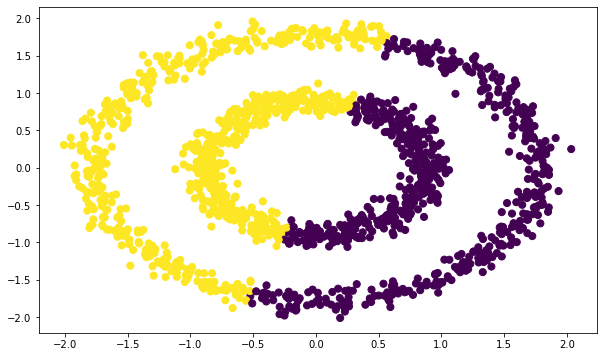

In [47]:
plt.scatter(CX[:, 0], CX[:, 1], c=y_gmm_pred, s=50, cmap='viridis')

Let's try a mixture model with the proteomes dataset.

In this example we compare 4 different covariance types: full (each component has its own general covariance matrix), tied (all components share the same general covariance matrix), diag (each component has its own diagonal covariance matrix), spherical (each component has its own single variance). 

This example shows that model selection can be performed with Gaussian Mixture Models using information-theoretic criteria (BIC). Model selection concerns both the covariance type and the number of components in the model. In that case, AIC also provides the right result (not shown to save time), but BIC is better suited if the problem is to identify the right model. Unlike Bayesian procedures, such inferences are prior-free.

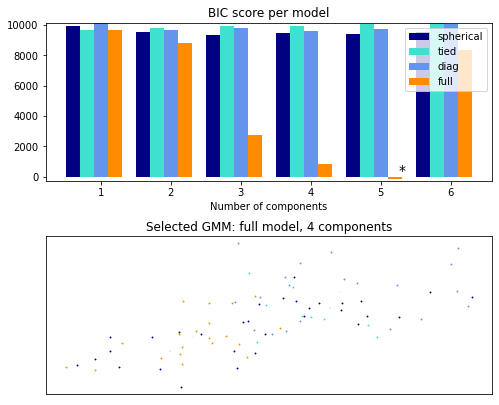

In [48]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(processed_p50)
        bic.append(gmm.bic(processed_p50))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(processed_p50)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(processed_p50[Y_ == i, 0], processed_p50[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 4 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

So what do we take from all this?

It is definetely not very straightforward which clustering method and what parameters (e.g. number of k) are suitable for a given problem. In the paper, the authors identify 3 subgroups with the KMeans algorithm. The other algorithms we tried gave us somewhat different results. The DBSCAN, for example, showed that the data was very dense and that it would group it into one cluster. The hierarchical clustering, however, chose 80 different clusters (which is almost the number of observations). In order to choose from the countless clustering algorithms, it helps to know your dataset. This means, knowing if the data is very dense, or if the dataset is incredibly large (and for that reason not suitable for the computationally heavy algorithms).

In the end, there is no such thing as a wrong-chosen algorithm – some of them are just more suitable for the particular dataset structures. In order to always pick up the best (read – more suitable) algorithm, you need to have a throughout understanding of their advantages, disadvantages, and peculiarities.

**References & additional resources:**
\
\
[Clustering overiew](https://developers.google.com/machine-learning/clustering)
\
[Another clustering overview]()
\
[K-Means explanation on YouTube](https://www.youtube.com/watch?v=hDmNF9JG3lo&feature=youtu.be) 
\
[K-Means handout](https://stanford.edu/~cpiech/cs221/handouts/kmeans.html)
\
[DBSCAN visualisation](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)
\
[GMM vc selection](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py)
\
[Overview of models](https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68)
\
[Model overview (also source of those brilliant gifs)](https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/)
\
[Final_exam_solutions](https://www.youtube.com/watch?v=DLzxrzFCyOs)
    